In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import time
import math

In [2]:
H, W = None, None # size of the frames

In [3]:
def read_video(path, interval):
    '''
    return: list l with ith element being the A.T, (frame x H*W)
    '''
    global H
    global W
    capture = cv.VideoCapture(path)
    frame_count = capture.get(cv.CAP_PROP_FRAME_COUNT)
    print('number of total frames:', frame_count)
    if interval == 1:
        size = int(frame_count - 1)
    else:
        size = math.ceil(frame_count/interval) 
    print('number of frames selected:', size)
    print('file opened:', capture.isOpened())  # return True if file can be opened
    count = 0
    num = 0

    if capture.isOpened():
        open, frame = capture.read()
        H, W = frame.shape[:-1]
    else:
        open = False
    l = [np.zeros((size,H*W)),np.zeros((size,H*W)),np.zeros((size,H*W))]
    while open:
        ret, frame = capture.read() # return two values: (bool, numpy.ndarray) 
        if frame is None:
            break
        if ret == True:
            if count % interval == 0:
                for i in range(3):
                    m = frame[:,:,i].flatten('F')
                    l[i][num] = m
                num += 1
            count += 1 
    return l
    
print()

In [4]:
def extract_background_scipy(A):
    '''
    return: flatten matrix of the background (H*W x 1)
    '''
    u, s, v = svds(A, k=1)
    u1 = u[:,-1]
    s1 = s[-1]
    v1 = v[-1]
    B = s1 * v1[0] * u1
    return B

def extract_background(A, threshold = 10**(-4)):
    # a = time.time()
    M = A.T @ A
    # b = time.time()
    # print('xxx', b-a)
    w = A.shape[1] # width of A i,e, # of frames selected
    x = [0] * w
    x[0] = 1
    v = np.full_like(x, (1/w)**0.5, dtype=np.double)
    sigma_sq = v.T @ M @ v
    i = 0
    while (np.linalg.norm((M@v - sigma_sq*v)/w)) > threshold:
        i += 1
        v_= M@v
        v = v_ / np.linalg.norm(v_)
        sigma_sq = v.T @ v_
    print('number of iterations:', i)
    B = v[0] * (A @ v)
    # print('------')
    return B, i

def extract_background_e1(A, threshold = 10**(-4)):
    # a = time.time()
    M = A.T @ A
    # b = time.time()
    # print('xxx', b-a)
    w = A.shape[1] # width of A i,e, # of frames selected
    x = [0] * w
    x[0] = 1
    v = np.array(x)
    sigma_sq = v.T @ M @ v
    i = 0
    while (np.linalg.norm((M@v - sigma_sq*v)/w)) > threshold:
        i += 1
        v_= M@v
        v = v_ / np.linalg.norm(v_)
        sigma_sq = v.T @ v_
    print('number of iterations:', i)
    B = v[0] * (A @ v)
    # print('------')
    return B, i

def extract_background_inverse(A, threshold = 10**(-4)):
    M = A.T@A
    w = A.shape[1] # width of A i,e, # of frames selected
    x = [0] * w
    v = np.full_like(x, (1/w)**0.5, dtype=np.double)
    sigma_sq = v.T @ M @ v
    sigma_sq_ = 0
    M_shift = M - sigma_sq * np.eye(w)
    M_shift_inv = np.linalg.inv(M_shift)
    i = 0
    while (np.linalg.norm((M@v - sigma_sq*v)/w)) > threshold:
        i += 1
        v_= M_shift_inv@v
        v = v_ / np.linalg.norm(v_)
        sigma_sq_, sigma_sq = sigma_sq, v.T @ M @ v
    print('number of iterations:',i)
    B = v[0] * (A @ v)
    return B, i

In [5]:
def run(path, algorithm = 'power', interval = 4):
    print('---creating matrix A---')
    L = read_video(path, interval)
    A1 = L[0].T.astype(float)
    A2 = L[1].T.astype(float)
    A3 = L[2].T.astype(float)
    # num = A1.shape[1]
    print('---extracting background---')
    ite1 = ite2 = ite3 = None
    if algorithm == 'scipy':
        print('channel1')
        a = time.time()
        img1 = extract_background_scipy(A1)
        print('channel2')
        img2 = extract_background_scipy(A2)
        print('channel3')
        img3 = extract_background_scipy(A3)
        b = time.time()
        # print('runtime of scipy package (three channels):', b-a)
    if algorithm == 'power':
        print('channel1')
        a = time.time()
        img1, ite1 = extract_background(A1)
        print('channel2')
        img2, ite2 = extract_background(A2)
        print('channel3')
        img3, ite3 = extract_background(A3)
        b = time.time()
        # print('runtime of our algorithm (three channels):', b-a)
    if algorithm == 'powere1':
        print('channel1')
        a = time.time()
        img1, ite1 = extract_background_e1(A1)
        print('channel2')
        img2, ite2 = extract_background_e1(A2)
        print('channel3')
        img3, ite3 = extract_background_e1(A3)
        b = time.time()
        # print('runtime of our algorithm (three channels):', b-a)
    if algorithm == 'inverse':
        print('channel1')
        a = time.time()
        img1, ite1 = extract_background_inverse(A1)
        print('channel2')
        img2, ite2 = extract_background_inverse(A2)
        print('channel3')
        img3, ite3 = extract_background_inverse(A3)
        b = time.time()
        # print('runtime of our algorithm (three channels):', b-a)
    print('---creating background image---')
    img1 = np.reshape(img1, (H, W), 'F')
    img2 = np.reshape(img2, (H, W), 'F')
    img3 = np.reshape(img3, (H, W), 'F')
    img1[img1>255] = 255
    img1[img1<0] = 0
    img2[img2>255] = 255
    img2[img2<0] = 0
    img3[img3>255] = 255
    img3[img3<0] = 0
    res = np.zeros((H,W,3))
    res[:,:,0] = img3 
    res[:,:,1] = img2 
    res[:,:,2] = img1 
    res = np.uint8(res)
    return res, b-a, [ite1, ite2, ite3]

In [6]:
path = '/Users/zhaosonglin/Desktop/test_videos/1280_720/city_02.mp4'

In [7]:
res1, t1 = run(path, 'scipy', 6)[:2]
print('runtime of scipy package (three channels):', t1)

---creating matrix A---
number of total frames: 918.0
number of frames selected: 153
file opened: True
---extracting background---
channel1
channel2
channel3
---creating background image---
runtime of scipy package (three channels): 12.217747926712036


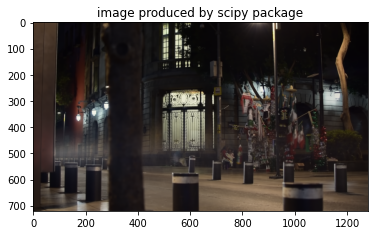

In [8]:
plt.imshow(res1)
plt.title('image produced by scipy package')
plt.show()

In [9]:
res2, t2 = run(path, 'power', 6)[:2]
print('runtime of our algorithm (three channels):', t2)

---creating matrix A---
number of total frames: 918.0
number of frames selected: 153
file opened: True
---extracting background---
channel1
number of iterations: 9
channel2
number of iterations: 8
channel3
number of iterations: 8
---creating background image---
runtime of our algorithm (three channels): 1.7982902526855469


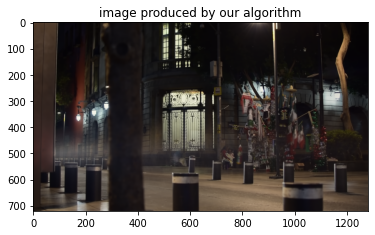

In [10]:
plt.imshow(res2)
plt.title('image produced by our algorithm')
plt.show()

### relationship between runtime and number of frames selected

In [11]:
def run(path, algorithm = 'power', interval = 4):
    L = read_video(path, interval)
    A1 = L[0].T.astype(float)
    A2 = L[1].T.astype(float)
    A3 = L[2].T.astype(float)
    ite1 = ite2 = ite3 = None
    if algorithm == 'scipy':
        a = time.time()
        img1 = extract_background_scipy(A1)
        img2 = extract_background_scipy(A2)
        img3 = extract_background_scipy(A3)
        b = time.time()
    if algorithm == 'power':
        a = time.time()
        img1, ite1 = extract_background(A1)
        img2, ite2 = extract_background(A2)
        img3, ite3 = extract_background(A3)
        b = time.time()
    if algorithm == 'powere1':
        a = time.time()
        img1, ite1 = extract_background_e1(A1)
        img2, ite2 = extract_background_e1(A2)
        img3, ite3 = extract_background_e1(A3)
        b = time.time()
    if algorithm == 'inverse':
        a = time.time()
        img1, ite1 = extract_background_inverse(A1)
        img2, ite2 = extract_background_inverse(A2)
        img3, ite3 = extract_background_inverse(A3)
        b = time.time()
    img1 = np.reshape(img1, (H, W), 'F')
    img2 = np.reshape(img2, (H, W), 'F')
    img3 = np.reshape(img3, (H, W), 'F')
    img1[img1>255] = 255
    img1[img1<0] = 0
    img2[img2>255] = 255
    img2[img2<0] = 0
    img3[img3>255] = 255
    img3[img3<0] = 0
    res = np.zeros((H,W,3))
    res[:,:,0] = img3 
    res[:,:,1] = img2 
    res[:,:,2] = img1 
    res = np.uint8(res)
    return res, b-a, [ite1, ite2, ite3]

---creating matrix A---
number of total frames: 340.0
number of frames selected: 339
file opened: True
---extracting background---
number of iterations: 7
number of iterations: 7
number of iterations: 7
---creating background image---
---creating matrix A---
number of total frames: 340.0
number of frames selected: 170
file opened: True
---extracting background---
number of iterations: 7
number of iterations: 7
number of iterations: 7
---creating background image---
---creating matrix A---
number of total frames: 340.0
number of frames selected: 114
file opened: True
---extracting background---
number of iterations: 7
number of iterations: 7
number of iterations: 7
---creating background image---
---creating matrix A---
number of total frames: 340.0
number of frames selected: 85
file opened: True
---extracting background---
number of iterations: 7
number of iterations: 7
number of iterations: 7
---creating background image---
---creating matrix A---
number of total frames: 340.0
number 

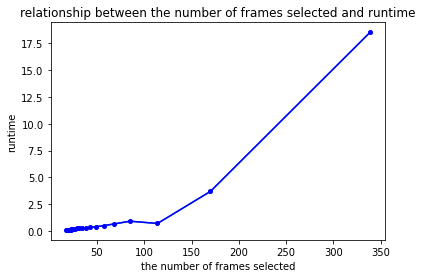

In [12]:
def chart():
    nums = []
    times = []
    path = '/Users/zhaosonglin/Desktop/test_videos/1280_720/road.mp4'
    for interval in range(1,21):
        print('---creating matrix A---')
        L = read_video(path, interval)
        A1 = L[0].T.astype(float)
        A2 = L[1].T.astype(float)
        A3 = L[2].T.astype(float)
        num = A1.shape[1]
        print('---extracting background---')
        a = time.time()
        img1 = extract_background(A1)[0]
        img2 = extract_background(A2)[0]
        img3 = extract_background(A3)[0]
        b = time.time()
        print('---creating background image---')
        img1 = np.reshape(img1, (H, W), 'F')
        img2 = np.reshape(img2, (H, W), 'F')
        img3 = np.reshape(img3, (H, W), 'F')
        img1[img1>255] = 255
        img1[img1<0] = 0
        img2[img2>255] = 255
        img2[img2<0] = 0
        img3[img3>255] = 255
        img3[img3<0] = 0
        res = np.zeros((H,W,3))
        res[:,:,0] = img3 
        res[:,:,1] = img2 
        res[:,:,2] = img1 
        res = np.uint8(res)
        nums.append(num)
        times.append(b-a)
    plt.plot(nums, times)
    plt.plot(nums, times, c='b', marker='o', markersize=4)
    plt.title('relationship between the number of frames selected and runtime')
    plt.xlabel('the number of frames selected')
    plt.ylabel('runtime')
    plt.show()

chart()

number of total frames: 351.0
number of frames selected: 71
file opened: True
number of iterations: 8
number of iterations: 8
number of iterations: 8
number of total frames: 351.0
number of frames selected: 71
file opened: True
number of iterations: 9
number of iterations: 9
number of iterations: 9
number of total frames: 1331.0
number of frames selected: 267
file opened: True
number of iterations: 7
number of iterations: 8
number of iterations: 8
number of total frames: 1331.0
number of frames selected: 267
file opened: True
number of iterations: 7
number of iterations: 7
number of iterations: 8
number of total frames: 650.0
number of frames selected: 130
file opened: True
number of iterations: 9
number of iterations: 8
number of iterations: 9
number of total frames: 650.0
number of frames selected: 130
file opened: True
number of iterations: 10
number of iterations: 10
number of iterations: 10
number of total frames: 882.0
number of frames selected: 177
file opened: True
number of it

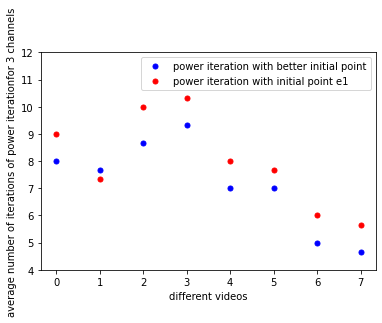

In [13]:
paths = ['/Users/zhaosonglin/Desktop/test_videos/640_360/sanfrancisco_01.mp4', '/Users/zhaosonglin/Desktop/test_videos/640_360/walking.mp4',
'/Users/zhaosonglin/Desktop/test_videos/1280_720/bangkok.mp4', '/Users/zhaosonglin/Desktop/test_videos/1280_720/tiger.mp4',
'/Users/zhaosonglin/Desktop/test_videos/1920_1080/waterwheel.mp4', '/Users/zhaosonglin/Desktop/test_videos/1920_1080/sunset.mp4',
'/Users/zhaosonglin/Desktop/test_videos/2560_1440/people_02.mp4', '/Users/zhaosonglin/Desktop/test_videos/2560_1440/street.mp4']
l1 = []
l2 = []
for p in paths:
    iteration1 = run(p, 'power', 5)[-1]
    iteration2 = run(p, 'powere1', 5)[-1]
    l1.append(np.mean(iteration1))
    l2.append(np.mean(iteration2))
plt.plot(range(8), l1, 'bo', markersize=5)
plt.plot(range(8), l2, 'ro', markersize=5)
plt.xlabel('different videos')
plt.ylabel('average number of iterations of power iterationfor 3 channels')
plt.legend(["power iteration with better initial point", "power iteration with initial point e1"], loc ="upper right")
plt.ylim((4,12))
plt.show()